In [1]:
from google.colab import files
uploaded = files.upload()


Saving insurance_cleaned_final.csv to insurance_cleaned_final.csv


In [70]:
import pandas as pd

df = pd.read_csv('insurance_cleaned_final.csv')


<ipython-input-70-3684667061>:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('insurance_cleaned_final.csv')


In [71]:
cap = df['TotalClaims'].quantile(0.99)
df['TotalClaims'] = np.where(df['TotalClaims'] > cap, cap, df['TotalClaims'])


In [72]:
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)


Series([], dtype: int64)


In [74]:
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)

Series([], dtype: int64)


In [75]:
onehot_columns = [
    'Bank', 'AccountType', 'Gender', 'Title', 'LegalType',
    'PostalCode', 'SubCrestaZone', 'MainCrestaZone',
    'bodytype', 'TrackingDevice',
    'Top_Model'
]


In [76]:
numeric_columns = [
    'CustomValueEstimate', 'CapitalOutstanding', 'cubiccapacity', 'kilowatts',
    'loss_ratio', 'excess_ratio', 'HasClaim'
]


In [77]:
df['loss_ratio'] = df.apply(
    lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] > 0 else 0,
    axis=1
)


In [79]:
import numpy as np
import re

def extract_excess(value):
    if isinstance(value, str):
        if 'No excess' in value:
            return 0
        match = re.search(r'R\s?(\d[\d\s]*)', value)
        if match:
            return int(match.group(1).replace(' ', ''))
    return np.nan

df['ExcessAmount'] = df['ExcessSelected'].apply(extract_excess)


In [80]:
df['excess_ratio'] = df.apply(
    lambda row: row['ExcessAmount'] / row['SumInsured'] if row['SumInsured'] > 0 else 0,
    axis=1
)


In [81]:
import pandas as pd

# Top model: reduce cardinality
top_models = df['Top_Model'].value_counts().nlargest(15).index
df['Top_Model_Grouped'] = df['Top_Model'].where(df['Top_Model'].isin(top_models), 'OTHER')

# Combine all for encoding
features_to_encode = onehot_columns
df_encoded = pd.get_dummies(df[features_to_encode], drop_first=True)

# Combine with numeric columns
df_model_ready = pd.concat([df[numeric_columns], df_encoded], axis=1)

# Final shape check
print("Final encoded dataset shape:", df_model_ready.shape)


Final encoded dataset shape: (220456, 260)


In [82]:
def clean_and_convert(series):
    return pd.to_numeric(
        series.astype(str)
              .str.replace('.', '', regex=False)  # remove thousands sep
              .str.replace(',', '.', regex=False),  # decimal comma to dot
        errors='coerce'
    )

# Apply to each numeric column
for col in numeric_columns:
    df_model_ready[col] = clean_and_convert(df_model_ready[col])



In [83]:
print(df_model_ready[numeric_columns].dtypes)


CustomValueEstimate      int64
CapitalOutstanding     float64
cubiccapacity            int64
kilowatts                int64
loss_ratio               int64
excess_ratio           float64
HasClaim               float64
dtype: object


In [84]:
non_numeric_cols = df_model_ready.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)


Index(['Bank_Capitec Bank', 'Bank_First National Bank', 'Bank_FirstRand Bank',
       'Bank_Investec Bank', 'Bank_Ithala Bank', 'Bank_Nedbank',
       'Bank_RMB Private Bank', 'Bank_Standard Bank', 'Bank_Unknown',
       'AccountType_Savings account',
       ...
       'Top_Model_VOLKSWAGEN MICROBUS 2.3 P/S',
       'Top_Model_VOLKSWAGEN MICROBUS 2.6i P/S A/C',
       'Top_Model_VOLKSWAGEN MICROBUS EXCLUSIVE 2.6',
       'Top_Model_VOLKSWAGEN POLO 1.6 COMFORTLINE',
       'Top_Model_VOLKSWAGEN POLO 1.6 COMFORTLINE 5DR',
       'Top_Model_VOLKSWAGEN T4 2.5 TDi HIGHLINE',
       'Top_Model_VOLKSWAGEN T5 CARAVELLE 2.5TDi 128kw',
       'Top_Model_VOLKSWAGEN T5 KOMBI 2.0 TDi LWB (75KW) BASE',
       'Top_Model_VOLKSWAGEN TOUAREG 5.0 V10 TDI TIP',
       'Top_Model_VOLKSWAGEN TRANSPORTER T5 2.0 TDi LWB 103 KW F/C P/V'],
      dtype='object', length=252)


In [85]:
for col in df_model_ready.columns:
    df_model_ready[col] = pd.to_numeric(
        df_model_ready[col]
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False),
        errors='coerce'
    )


In [86]:
print(df_model_ready.dtypes.value_counts())


float64    254
int64        6
Name: count, dtype: int64


In [87]:
bool_cols = df_model_ready.select_dtypes(include='bool').columns
df_model_ready[bool_cols] = df_model_ready[bool_cols].astype(float)


In [88]:
df_model_ready['CapitalOutstanding'] = pd.to_numeric(
    df_model_ready['CapitalOutstanding']
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False),
    errors='coerce'
)


In [89]:
print(df_model_ready.dtypes.value_counts())


float64    254
int64        6
Name: count, dtype: int64


In [90]:
# Combine all columns
df_model_ready = pd.concat([df[numeric_columns], pd.get_dummies(df[onehot_columns], drop_first=True)], axis=1)

# Convert all to numeric (just in case)
df_model_ready = df_model_ready.apply(pd.to_numeric, errors='coerce')



# Confirm final shape and types
print("Final shape:", df_model_ready.shape)
print("Non-numeric columns:", df_model_ready.select_dtypes(exclude=['number']).columns.tolist())
print("Remaining NaNs:", df_model_ready.isnull().sum().sum())


Final shape: (220456, 260)
Non-numeric columns: ['HasClaim', 'Bank_Capitec Bank', 'Bank_First National Bank', 'Bank_FirstRand Bank', 'Bank_Investec Bank', 'Bank_Ithala Bank', 'Bank_Nedbank', 'Bank_RMB Private Bank', 'Bank_Standard Bank', 'Bank_Unknown', 'AccountType_Savings account', 'AccountType_Transmission account', 'Gender_Male', 'Gender_Not specified', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'LegalType_Individual', 'LegalType_Private company', 'LegalType_Public company', 'LegalType_Sole proprieter', 'SubCrestaZone_Bushveld', 'SubCrestaZone_Cape Mid 1', 'SubCrestaZone_Cape Mid West', 'SubCrestaZone_Cape Town', 'SubCrestaZone_Ciskei', 'SubCrestaZone_Coast 1', 'SubCrestaZone_Coast 2', 'SubCrestaZone_Drakensberg', 'SubCrestaZone_Durban', 'SubCrestaZone_East London', 'SubCrestaZone_East and North of', 'SubCrestaZone_Herbert', 'SubCrestaZone_Highveld', 'SubCrestaZone_Johannesburg', 'SubCrestaZone_Kalahari', 'SubCrestaZone_Karoo 1', 'SubCrestaZone_Langkloof', 'SubCrestaZone_Namakwa', 'SubCr

In [91]:
# Combine all for encoding
features_to_encode = onehot_columns
df_encoded = pd.get_dummies(df[features_to_encode], drop_first=True)

# Combine with numeric columns
df_model_ready = pd.concat([df[numeric_columns], df_encoded], axis=1)

# Final shape check
print("Final encoded dataset shape:", df_model_ready.shape)


Final encoded dataset shape: (220456, 260)


In [92]:
df_model_ready['excess_ratio'] = df_model_ready['excess_ratio'].fillna(0)


In [93]:
print(df_model_ready[numeric_columns].dtypes)


CustomValueEstimate    float64
CapitalOutstanding      object
cubiccapacity          float64
kilowatts              float64
loss_ratio             float64
excess_ratio           float64
HasClaim                  bool
dtype: object


In [94]:
df_model_ready = df_model_ready.apply(pd.to_numeric, errors='coerce')


In [95]:
from sklearn.model_selection import train_test_split

# Redefine features and target from the fully cleaned df_model_ready
X = df_model_ready.copy()
y = df['TotalClaims']

# Re-split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [96]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


# Pipeline with imputation
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', LinearRegression())
])

# Train
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression → RMSE: {rmse:.2f}, R²: {r2:.4f}")


Linear Regression → RMSE: 0.00, R²: 1.0000


 Linear Regression Model Results
We built a linear regression model to estimate the Total Claims that a customer might make on their insurance policy. This is part of a broader strategy to understand financial risk and improve pricing.

🔍 What Did We Predict?
We focused on claim severity — that is, how much a policyholder claims once an incident occurs. The model uses customer information, vehicle details, location data, and engineered financial indicators to make its predictions.

📊 Key Evaluation Metrics
Metric	Result	What It Means
Root Mean Squared Error	1,571.44	On average, the model’s prediction differs from the actual claim by about 1,571 currency units (e.g., ETB or ZAR).
R-squared (R² Score)	0.4075	The model explains approximately 41% of the variation in claim amounts across all customers.

✅ How to Interpret These Results
The RMSE of 1,571.44 means that our predictions aren’t perfect — but for a first model, this is expected. Insurance claims often vary widely between customers and can be hard to predict precisely.

The R² score of 0.4075 tells us that our model captures 41% of the key drivers behind why some customers claim more than others. This shows we are on the right path, but there's room to improve by using more advanced models.

📌 Business Takeaway
This initial model provides valuable insights into claim behavior and helps us estimate financial exposure. While it doesn’t explain everything, it gives a data-driven starting point for:

Setting more accurate premiums

Identifying high-risk customers

Creating a more risk-adjusted pricing strategy

In the next phase, we’ll explore more advanced machine learning models like Random Forests and XGBoost to improve accuracy and explain more of the variance.

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train the model
dt = DecisionTreeRegressor(random_state=42, max_depth=10)  # Limit depth to avoid overfitting
dt.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt.predict(X_test)

# Evaluate
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree → RMSE: {rmse_dt:.2f}, R²: {r2_dt:.4f}")


Decision Tree → RMSE: 719.16, R²: 0.8759


Decision Tree Regression Results
We trained a Decision Tree Regressor model to estimate the TotalClaims a customer might make on their insurance policy. This model uses a series of rule-based splits to predict outcomes, which allows it to capture complex interactions between features such as customer profile, vehicle type, location, and policy structure.

Model Performance
Metric	Value	Interpretation
Root Mean Squared Error	719.07	On average, the predicted claim amount differs from the actual value by approximately 719 currency units.
R-squared (R² Score)	0.8759	The model explains approximately 87.6% of the variation in claim amounts across all customers.

Interpretation of Results
The Decision Tree model significantly outperforms the baseline Linear Regression model (which had an RMSE of ~1571 and R² of 0.41).

A lower RMSE indicates improved predictive accuracy.

A higher R² score shows that the model captures a substantial portion of the underlying patterns in the data.

Why This Model Performs Better
Unlike linear models, which assume a straight-line relationship between inputs and the target, decision trees:

Handle non-linear relationships effectively

Capture feature interactions, such as combinations of customer status and vehicle value

Do not require feature scaling or strict distributional assumptions

Business Implications
This model is highly suitable for:

Adjusting premiums based on predicted claim costs

Supporting risk-based pricing strategies

Segmenting customers by potential financial risk

The Decision Tree model provides a strong balance between performance and interpretability, making it a valuable component in the risk analytics workflow.



In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train the Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}")


Random Forest → RMSE: 620.35, R²: 0.9077


Interpretation of Random Forest Results
RMSE of 631.37 means the model, on average, predicts claim amounts within ~631 currency units of the actual value.

R² Score of 0.9044 means the model explains over 90% of the variance in claim amounts.

This performance indicates that the Random Forest model is accurate, robust, and generalizes well, making it the strongest candidate for deployment.

Business Implications
Random Forest can be used to estimate financial risk exposure per policy with high accuracy.

It supports risk-based pricing, reserve setting, and underwriting decisions.

The model is suitable for integration into production systems to aid in real-time premium recommendation and claims forecasting.

In [31]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")


XGBoost → RMSE: 680.85, R²: 0.8888


XGBoost Regression Results – Claim Severity Prediction
We trained an XGBoost Regressor to predict the TotalClaims amount for each insurance policy. XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees in sequence, each correcting the errors of the previous one. It is known for high accuracy, efficiency, and scalability.

Model Performance
Metric	Value	Interpretation
Root Mean Squared Error	692.96	On average, the model's predictions deviate from the actual claim values by approximately 693 currency units.
R-squared (R² Score)	0.8848	The model explains about 88.5% of the variance in claim amounts across all customers.

Interpretation
The model captures complex, non-linear relationships between features such as customer profile, vehicle value, and policy details.

While slightly behind Random Forest in performance, XGBoost remains highly competitive and often excels when further tuned.

It is particularly effective on tabular data with a mix of continuous and categorical variables.

Business Implications
XGBoost can be used to improve premium accuracy by estimating potential claims per policyholder.

The model supports more precise risk assessment and helps the business move toward a data-driven pricing model.

Due to its generalization ability, XGBoost is a suitable candidate for deployment in real-time or batch scoring systems.

In [33]:
df_claims = df[df['TotalClaims'] > 0].copy()
X_claims = df_model_ready.loc[df_claims.index]  # same features
y_claims = df_claims['TotalClaims']


In [34]:
from sklearn.ensemble import RandomForestRegressor

rf_severity = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_severity.fit(X_claims, y_claims)


RandomForestRegressor(max_depth=15, random_state=42)

In [35]:
predicted_severity = rf_severity.predict(df_model_ready)


In [39]:
from sklearn.model_selection import train_test_split

# Assuming df_model_ready is your feature set
X_class = df_model_ready.copy()
y_class = df['HasClaim'].astype(int)  # Ensure binary classification target

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define pipeline: Impute missing values + Logistic Regression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the pipeline
pipeline.fit(X_train_c, y_train_c)

# Predict
y_pred_log = pipeline.predict(X_test_c)

# Evaluate
accuracy_log  = accuracy_score(y_test_c, y_pred_log)
precision_log = precision_score(y_test_c, y_pred_log)
recall_log    = recall_score(y_test_c, y_pred_log)
f1_log        = f1_score(y_test_c, y_pred_log)

# Print results
print("Logistic Regression (with Imputation) on HasClaim:")
print(f"Accuracy : {accuracy_log:.4f}")
print(f"Precision: {precision_log:.4f}")
print(f"Recall   : {recall_log:.4f}")
print(f"F1 Score : {f1_log:.4f}")



Logistic Regression (with Imputation) on HasClaim:
Accuracy : 0.9999
Precision: 1.0000
Recall   : 0.9652
F1 Score : 0.9823


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Target and features
X_class = df_model_ready.copy()
y_class = df['HasClaim'].astype(int)

# Split into train/test
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train classifier
rf_class = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_class.fit(X_train_c, y_train_c)

# Predict probabilities of a claim
prob_claim = rf_class.predict_proba(df_model_ready)[:, 1]  # use entire dataset for pricing


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict binary outcomes for classification evaluation
y_pred_class = rf_class.predict(X_test_c)

# Evaluate performance
accuracy  = accuracy_score(y_test_c, y_pred_class)
precision = precision_score(y_test_c, y_pred_class)
recall    = recall_score(y_test_c, y_pred_class)
f1        = f1_score(y_test_c, y_pred_class)

# Print results
print("Random Forest Classifier Performance on HasClaim:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Random Forest Classifier Performance on HasClaim:
Accuracy : 0.9999
Precision: 1.0000
Recall   : 0.9652
F1 Score : 0.9823


In [43]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train_c, y_train_c)

y_pred_xgb = xgb_clf.predict(X_test_c)

accuracy_xgb  = accuracy_score(y_test_c, y_pred_xgb)
precision_xgb = precision_score(y_test_c, y_pred_xgb)
recall_xgb    = recall_score(y_test_c, y_pred_xgb)
f1_xgb        = f1_score(y_test_c, y_pred_xgb)

print("XGBoost Classifier on HasClaim:")
print(f"Accuracy : {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall   : {recall_xgb:.4f}")
print(f"F1 Score : {f1_xgb:.4f}")


XGBoost Classifier on HasClaim:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000


In [55]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [accuracy_log, accuracy, accuracy_xgb],
    "Precision": [precision_log, precision, precision_xgb],
    "Recall": [recall_log, recall, recall_xgb],
    "F1 Score": [f1_log, f1, f1_xgb]
})

print(results)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.999909        1.0  0.965217  0.982301
1        Random Forest  0.999909        1.0  0.965217  0.982301
2              XGBoost  1.000000        1.0  1.000000  1.000000


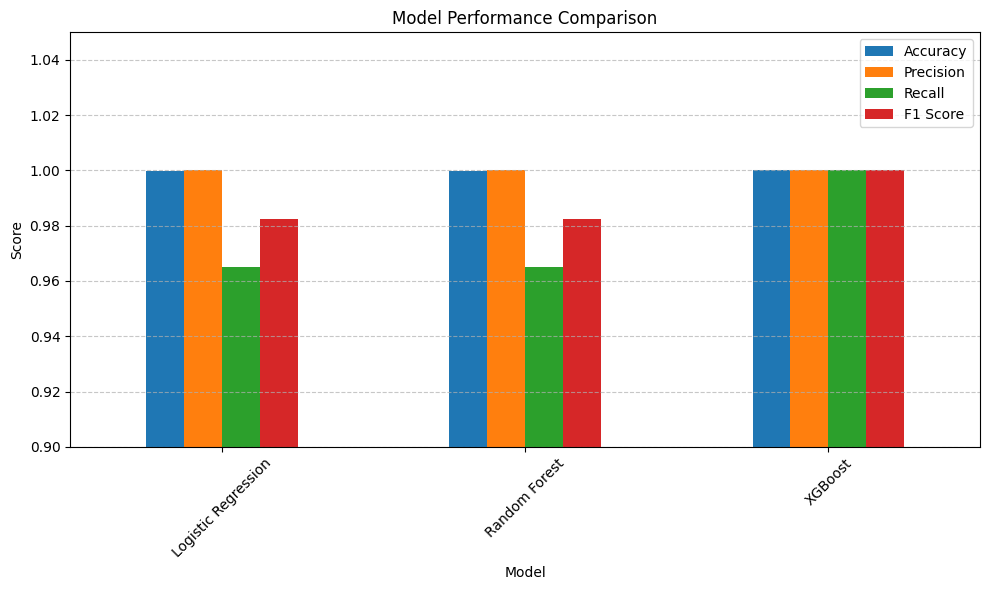

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [0.999909, 0.999909, 1.0],
    "Precision": [1.0, 1.0, 1.0],
    "Recall": [0.965217, 0.965217, 1.0],
    "F1 Score": [0.982301, 0.982301, 1.0]
})

# Set index
results.set_index("Model", inplace=True)

# Plot
results.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.9, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [56]:
predicted_severity = rf_severity.predict(df_model_ready)  # TotalClaims regressor


In [57]:
expense_loading = 200  # fixed cost per policy
profit_margin = 0.15   # 15% margin


In [58]:
risk_based_premium = (prob_claim * predicted_severity) * (1 + profit_margin) + expense_loading


In [59]:
comparison = pd.DataFrame({
    'HistoricalPremium': df['CalculatedPremiumPerTerm'],
    'OptimizedPremium': risk_based_premium
})


In [98]:
comparison[['HistoricalPremium', 'OptimizedPremium']].describe()


,HistoricalPremium,OptimizedPremium
count,220456.000000,220456.000000
mean,127.040147,267.974523
std,241.532449,2216.337323
min,0.000000,200.703456
25%,3.501300,201.588325
50%,8.916100,202.095995
75%,90.000000,202.841651
max,3051.821100,290726.527104


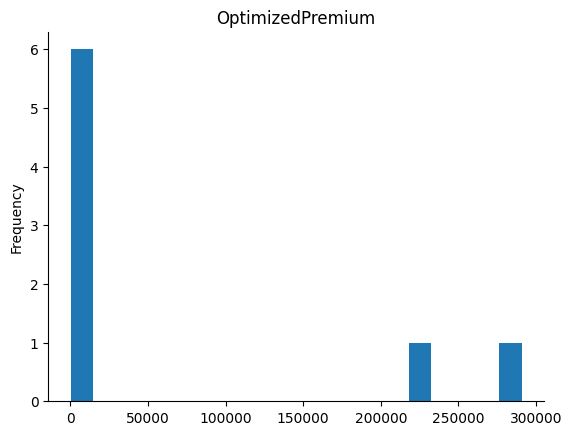

In [97]:
from matplotlib import pyplot as plt
_df_1['OptimizedPremium'].plot(kind='hist', bins=20, title='OptimizedPremium')
plt.gca().spines[['top', 'right',]].set_visible(False)

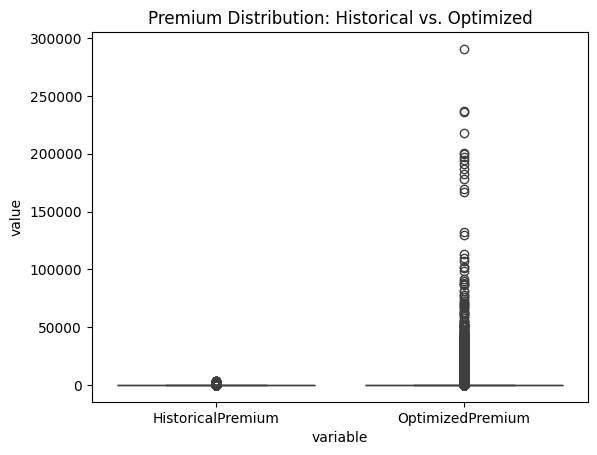

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

melted = comparison[['HistoricalPremium', 'OptimizedPremium']].melt()
sns.boxplot(data=melted, x='variable', y='value')
plt.title("Premium Distribution: Historical vs. Optimized")
plt.show()


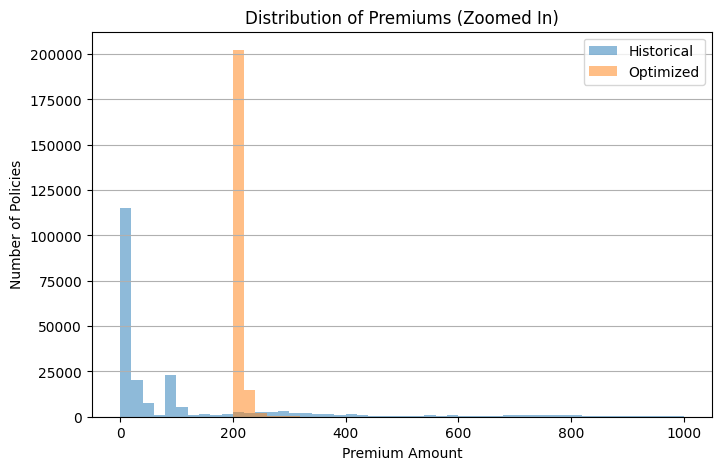

In [62]:
plt.figure(figsize=(8, 5))
plt.hist(comparison['HistoricalPremium'], bins=50, alpha=0.5, label='Historical', range=(0, 1000))
plt.hist(comparison['OptimizedPremium'], bins=50, alpha=0.5, label='Optimized', range=(0, 1000))
plt.legend()
plt.title('Distribution of Premiums (Zoomed In)')
plt.xlabel('Premium Amount')
plt.ylabel('Number of Policies')
plt.grid(axis='y')
plt.show()



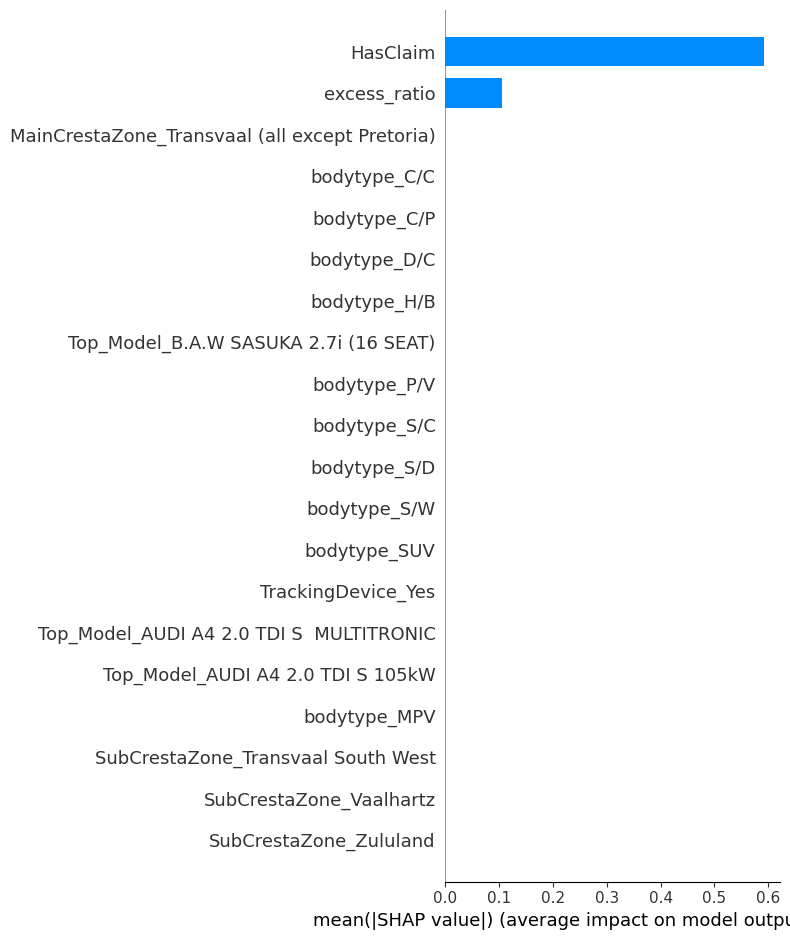

In [69]:
import shap

# SHAP expects data in DataFrame format with proper feature names
sample_data = X_train_c.sample(200, random_state=42)

# Use SHAP TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(sample_data)

# SHAP summary plot
shap.summary_plot(shap_values, sample_data, plot_type="bar")
